# Find rain days in a specified region, given 8 upper atm variables and respective Gridmet data.

This notebook calculates average rain on a 128x128 grid, it then averages the respective 8 upper atm variables. 

* this version loads netcdf files directly via xarray
* "Gridmet data" can now be replaced with any model's output

### TODO items

* better graphs (i.e. include lat/lon scale)



In [1]:
from IPython import display
import numpy as np

#from skimage.metrics import structural_similarity as ssim
import copy


In [2]:
# load netcdf files directly via xarray
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy

# Configuration

In [3]:
# Ordering: nRow ordering: obs, raw, RegCM4, WRF, MPAS, CNN, SDSM, KDDM, MBCn, LOCA
mpi_sigfiles=['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpi/rcp85/prec.rcp85.MPI-ESM-LR.raw.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/wrf/rcp85/prec.rcp85.MPI-ESM-LR.WRF.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mpas/rcp85/prec.rcp85.MPI-ESM-LR.MPAS.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/cnn/rcp85/prec.rcp85.MPI-ESM-LR.CNN.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/sdsm/rcp85/prec.rcp85.MPI-ESM-LR.SDSM.day.2070-2099.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/kddm/rcp85/prec.rcp85.MPI-ESM-LR.KDDM.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hist.MPI-ESM-LR.MBCn.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/mbcn/rcp85/prec.rcp85.MPI-ESM-LR.MBCn.day.2075-2100.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/hist/prec.hist.MPI-ESM-LR.LOCA.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
'/glade/work/mcginnis/DCA/data/gen/final/loca/rcp85/prec.rcp85.MPI-ESM-LR.LOCA.day.2075-2100.NAM-22i.SGP.x098.y36.nc']

# Compact Configuration

In [4]:
sigdir = '/glade/work/mcginnis/DCA/data/gen/final'
def model2absfilepath(mn, exp, x, y):
    if mn == 'obs' or mn == 'gridMET':
        mn = 'gridMET'
        filename = 'prec.{}.gridMET.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'obs', x, y)
    elif mn == 'raw' or mn == 'mpi':
        mn = 'mpi'
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, 'raw', x, y)
        else: print("Unknown experiment!")
    elif mn == 'SDSM':  # starts at 1976
        if exp == 'hist':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.1976-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        elif exp == 'rcp85':
            filename = 'prec.{}.MPI-ESM-LR.{}.day.2070-2099.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
        else: print("Unknown experiment!")

    elif exp == 'hist':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.1980-2005.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    elif exp == 'rcp85':
        filename = 'prec.{}.MPI-ESM-LR.{}.day.2075-2100.NAM-22i.SGP.x0{}.y{}.nc'.format(exp, mn, x, y)
    else: print("Unknown experiment!")
    return sigdir + '/' + mn.lower() + '/' + exp + '/' + filename
    

In [5]:
# test single file
model2absfilepath('RegCM4', 'rcp85', 98, 36)

'/glade/work/mcginnis/DCA/data/gen/final/regcm4/rcp85/prec.rcp85.MPI-ESM-LR.RegCM4.day.2075-2100.NAM-22i.SGP.x098.y36.nc'

In [6]:
# create list of abs filepaths
[model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]


['/glade/work/mcginnis/DCA/data/gen/final/gridmet/hist/prec.hist.gridMET.obs.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpi/hist/prec.hist.MPI-ESM-LR.raw.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/regcm4/hist/prec.hist.MPI-ESM-LR.RegCM4.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/wrf/hist/prec.hist.MPI-ESM-LR.WRF.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mpas/hist/prec.hist.MPI-ESM-LR.MPAS.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/cnn/hist/prec.hist.MPI-ESM-LR.CNN.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/sdsm/hist/prec.hist.MPI-ESM-LR.SDSM.day.1976-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/kddm/hist/prec.hist.MPI-ESM-LR.KDDM.day.1980-2005.NAM-22i.SGP.x098.y36.nc',
 '/glade/work/mcginnis/DCA/data/gen/final/mbcn/hist/prec.hi

### Load model output data

In [7]:
##################
## LOAD GRIDMET ##
##################
# 1980-1989
istart = 365
#ndays = 3653  # 1980-1989
ndays = 13515 # 1980-2016 

dv1 = xr.open_dataset('/glade/work/dkorytin/srgan_data/prec128_gridmetA_1979-2016.nc')['prec'][istart:istart+ndays]
# dv2 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmax128_gridmetA_1979-2016.nc')['tmax'][istart:istart+ndays]
# dv3 = xr.open_dataset('/glade/work/dkorytin/srgan_data/tmin128_gridmetA_1979-2016.nc')['tmin'][istart:istart+ndays]
# dv4 = xr.open_dataset('/glade/work/dkorytin/srgan_data/uas128_gridmetA_1979-2016.nc')['uas'][istart:istart+ndays]
# dv5 = xr.open_dataset('/glade/work/dkorytin/srgan_data/vas128_gridmetA_1979-2016.nc')['vas'][istart:istart+ndays]
# dv6 = xr.open_dataset('/glade/work/dkorytin/srgan_data/huss128_gridmetA_1979-2016.nc')['huss'][istart:istart+ndays]
# dv7 = xr.open_dataset('/glade/work/dkorytin/srgan_data/rsds128_gridmetA_1979-2016.nc')['rsds'][istart:istart+ndays]
# dv8 = xr.open_dataset('/glade/work/dkorytin/srgan_data/miss128_gridmetB_1979-2016.nc')['miss'][istart:istart+ndays]




### Load MPI UATM data

In [8]:
###########################
## LOAD ERAI data: daily ##
###########################
def load_uatm_erai():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    # load eraionmpi
    #mndays = 11688      # 1979-2010
    mstart = 365
    mndays = 13515       # 1980-2016 
    mnvars = 8*1
    mdv1 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U850.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv2 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V850.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]
    mdv3 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Q850.ERAI.MPIGRID.1979-2018.nc')['Q'][mstart:mstart+mndays*1]
    mdv4 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/T700.ERAI.MPIGRID.1979-2018.nc')['T'][mstart:mstart+mndays*1]
    mdv5 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z700.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv6 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/Z500.ERAI.MPIGRID.1979-2018.nc')['Z'][mstart:mstart+mndays*1]
    mdv7 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/U250.ERAI.MPIGRID.1979-2018.nc')['U'][mstart:mstart+mndays*1]
    mdv8 = xr.open_dataset('/glade/scratch/dkorytin/erai-on-mpigrid/V250.ERAI.MPIGRID.1979-2018.nc')['V'][mstart:mstart+mndays*1]

    print("Days loaded", len(mdv7))


In [9]:
###################
## LOAD MPI      ##
###################  
def load_uatm_mpi_hist():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    mnvars = 8
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/historical/'

    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_historical_r1i1p1_NAmerica_p850_19500101-20051231_dayavg_mpigrid.nc')['Q'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['T'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p700_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_historical_r1i1p1_NAmerica_p500_19500101-20051231_dayavg_mpigrid.nc')['Z'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['U'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_historical_r1i1p1_NAmerica_p250_19500101-20051231_dayavg_mpigrid.nc')['V'].sel(time=slice('1976-01-01T00:00:00', '2006-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

def load_uatm_mpi_future():
    global mdv1,mdv2,mdv3,mdv4,mdv5,mdv6,mdv7,mdv8,mnvars
    
    d='/glade/p/ral/risc/rmccrary/CMIP5_CORDEX/NAmerica/MPI-ESM-LR/native/rcp85/'

    mnvars = 8
    mdv1 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv2 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv3 = xr.open_dataset(d+'Q_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p850_20060101-21001231_dayavg_mpigrid.nc')['Q'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv4 = xr.open_dataset(d+'T_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['T'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv5 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p700_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv6 = xr.open_dataset(d+'Z_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p500_20060101-21001231_dayavg_mpigrid.nc')['Z'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv7 = xr.open_dataset(d+'U_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['U'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))
    mdv8 = xr.open_dataset(d+'V_MPI-ESM-LR_rcp85_r1i1p1_NAmerica_p250_20060101-21001231_dayavg_mpigrid.nc')['V'].sel(time=slice('2006-01-01T00:00:00', '2101-01-01T00:00:00'), lat=slice(23,56), lon=slice(-113,-80))

#load_uatm_mpi_future()


# Plot routines

In [39]:
# plot average rain inputs
def plot_8v(isample):
    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
    fig, axarr = plt.subplots(1, 8, figsize = (20,20))
    for ii in range(8):
        plot = axarr[ii].imshow(isample[ii])
        cbar = fig.colorbar(plot, ax=axarr[ii], orientation="horizontal", fraction=0.046, pad=0.016)
        cbar.set_label(units[ii])
        axarr[ii].set_title(varmames[ii])
    plt.show()


In [134]:
# POSTAGE STAMP LAYOUT
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature

from os.path import basename
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
from matplotlib import ticker

import warnings
warnings.filterwarnings("ignore")

   

#def plot_postage(avginput_list, title): 
def plot_postage(avginput_list, model_names, miss_counts, all_days_count, title):

    varmames = ['U850', 'V850', 'Q850', 'T700', 'Z700', 'Z500', 'U250', 'V250']
    units = ['m/s', 'm/s', 'kg/kg', 'K', 'mb', 'mb', 'm/s', 'm/s']
        
    # find min/max values for entire sigfiles set
    vmin = np.zeros(8) 
    vmax = np.zeros(8) 
    for vii in range(8):
        # find min
        all_plots = np.array(copy.deepcopy(avginput_list))
        all_plots[np.isnan(all_plots)] = 9999
        vmin[vii] = all_plots[:,vii].min()        
        # find max
        all_plots = np.array(copy.deepcopy(avginput_list))
        all_plots[np.isnan(all_plots)] = -9999
        vmax[vii] = all_plots[:,vii].max()
        
        
    # CLIM colors
    cmaps = ['PiYG', 'PuOr', 'BrBG', 'RdBu_r', 'Spectral', 'Spectral', 'PiYG', 'PuOr']  # CLIM
    # ALL Ranges centered on zero for U, V
    for ii in range(8):
        vmin[ii] = -max(abs(vmin[ii]), abs(vmax[ii]))
        vmax[ii] = max(abs(vmin[ii]), abs(vmax[ii]))   

    
#     #fig, axarr = plt.subplots(nrows=3, ncols=8, figsize = (10,10*(3/8.+0.0)), gridspec_kw={'hspace': 0.0, 'wspace': 0.0, 'height_ratios':[1,1,1.3]})
    fig, axarr = plt.subplots(nrows=len(avginput_list), ncols=8, figsize = (20,20*(len(avginput_list)/8.+0.0)), subplot_kw={'projection': ccrs.PlateCarree()}, gridspec_kw={'hspace': 0.0, 'wspace': 0.0, 'height_ratios':[1]*(len(avginput_list)-1)+[1.313]})
    lon = mdv1[0].lon
    lat = mdv1[0].lat

    
    # plots 
    for jj in range(len(avginput_list)):

        for ii in range(8):
            axarr[jj,ii].coastlines()
            axarr[jj,ii].add_feature(cfeature.STATES)
            img_extent = (lon.min(), lon.max(), lat.min(), lat.max())

            #plot = axarr[jj,ii].imshow(avginput[ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii])
            plot = axarr[jj,ii].imshow(avginput_list[jj][ii][::-1,:], vmin=vmin[ii], vmax=vmax[ii], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  
            #plot = axarr[jj,ii].imshow(avginput_list[jj][ii][::-1,:], cmap=cmaps[ii], origin='upper', extent=img_extent, transform=ccrs.PlateCarree())  

            # show y tics on first column
            if ii==0:
                axarr[jj,ii].get_yaxis().set_visible(True)
                axarr[jj,ii].tick_params(labelsize='xx-small')

                # We need to draw the canvas, otherwise the labels won't be positioned and 
                # won't have values yet.
                fig.canvas.draw()

                # lat range: 56 to 23
                labels = [item.get_text() for item in axarr[jj,ii].get_yticklabels()]
                #labels = ['56','46','36','26']
                axarr[jj,ii].set_yticklabels(labels)

            ## show y labels on last column
            #if ii==7:
                ##axarr[jj,ii].get_yaxis().set_visible(True)
                ##axarr[jj,ii].tick_params(labelsize='xx-small')
                #
                #cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.03, pad=0.2)
                #
                #
                ##ax.set_ylabel("Label", rotation=270)
                #
                ##cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="vertical", fraction=0.046, pad=0.016)
                #cbar.set_label('dry', rotation=90, size='xx-small')
                #cbar.ax.tick_params(labelsize='xx-small')





            if ii>=1:
                axarr[jj,ii].get_yaxis().set_visible(False)
                axarr[jj,ii].tick_params(labelsize='xx-small')



            if jj == 0:
                axarr[jj,ii].set_title(varmames[ii])
                axarr[jj,ii].get_xaxis().set_visible(False)
                axarr[jj,ii].tick_params(labelsize='xx-small')

            if jj==1:
                axarr[jj,ii].get_xaxis().set_visible(False)
                #axarr[jj,ii].tick_params(labelsize='xx-small')

            # show custom tics on bottom row: lon=slice(-113,-80)
            if jj==len(avginput_list)-1:
                axarr[jj,ii].get_xaxis().set_visible(True)
                axarr[jj,ii].tick_params(labelsize='xx-small')

                # We need to draw the canvas, otherwise the labels won't be positioned and 
                # won't have values yet.
                fig.canvas.draw()

                labels = [item.get_text() for item in axarr[jj,ii].get_xticklabels()]
                #labels[1] = '-113'
                #labels[2] = '-103'
                #labels[3] = '-93'
                ##labels[4] = '-83'
                axarr[jj,ii].set_xticklabels(labels)




            # colorbar only on 3rd postage stamp
            if jj==len(avginput_list)-1:
                # use scientific notation on 3rd column colorbar only
                if ii == 2:     
                    def fmt(x, pos):
                        a, b = '{:.1e}'.format(x).split('e')
                        b = int(b)
                        return r'${}e{}$'.format(a, b)
                    cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format=ticker.FuncFormatter(fmt))
                    #cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format='%.0e') #format=ticker.FuncFormatter(fmt))
                    #cbar.set_ticks([0.2, 0.4, 0.6, 0.8])
                    #cbar.set_ticklabels(["A", "B", "C", "D"])
                    tick_locator = ticker.MaxNLocator(nbins=4)
                    cbar.locator = tick_locator
                    cbar.update_ticks()
                else:
                    cbar = fig.colorbar(plot, ax=axarr[jj,ii], orientation="horizontal", fraction=0.0385, pad=0.2, format=None)                    

                cbar.set_label(units[ii], size='xx-small')
                cbar.ax.tick_params(labelsize='xx-small')
                    
            # row titles
            #sigfilename = basename(sigfile)
            ##print ("days:", count, ", model:", sigfilename)
            #label = ' '.join(sigfn1.split('.')[3:4])
            label = 'nolabel'

            nrows = len(avginput_list)
            #plt.figtext(0.09, 1-(1.4/nrows)-jj*(.73/nrows), label+': '+str(int(counts[jj]*100))+'%', fontsize=11, rotation=90)
            #plt.figtext(0.095, 1-(1.55/9)-jj*(.74/nrows), label+': '+str(int(counts1[jj]*100))+'%', fontsize=11, weight='normal', rotation=90)
            plt.figtext(0.095, 1-(1.55/9)-jj*(.74/nrows), model_names[jj]+': '+str(int(miss_counts[jj]))+'/'+str(int(all_days_count))+'', fontsize=11, weight='normal', rotation=90)


        

#         # row title
#         sigfilename = basename(sigfile)
#         #print ("days:", count, ", model:", sigfilename)
#         rowtitle = ' '.join(sigfilename.split('.')[0:4]) # + ' Count: '+str(counts)

        # title
        #fig.suptitle(title, y=1.05, fontsize=14)
        #fig.suptitle(title, y=1-(.5/nrows), fontsize=14, fontweight="bold")
        fig.suptitle(title, y=0.92, fontsize=14)

        
        #plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0, hspace=0)
        #plt.subplots_adjust(wspace=0, hspace=0)
        #plt.subplots_adjust(wspace=0.0, hspace=0, right=0.7)

    plt.show()
        


# Averaging code

In [10]:
###################
## UATM averages ##
###################

def calc_uatm_average(mpr_min, mpr_max, rainsignal, ymin, ymax):
    # global inputs: dv[1-8], mdv[1-8], mnvars
    mnvars = 8
    
    # initialize accumulators
    indices = []
    distribution = []
    raw_ires = len(mdv1[0])
    raininput = np.zeros((mnvars, raw_ires, raw_ires))
    raincount = 0
    
    for ii in range(0,len(rainsignal)):
        mpr = rainsignal[ii]
            
        # May = 5
        if mpr["time.month"] == 5 and mpr["time.year"] >= ymin and mpr["time.year"] <= ymax:    



            if mpr >= mpr_min and mpr < mpr_max:
                distribution.append(mpr)
                indices.append(ii)

                #mpr = dv1[ii].sel(lat=slice(32.125,38.125), lon=slice(-101.875,-93.875)).mean()

                # find matching input sample 
                #ot= dv1[ii-1]['time']
                ot = str(np.array(mpr['time']))

                mdv1.sel(time=ot,method='nearest')
                isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
                #ot= dv1[ii]['time']
                #assert ot["time.day"]==isample[0]['time.day'], "Days are not equal"
                isample = np.array(isample)

                raininput += isample
                raincount += 1
            
    raininput /= raincount
    #print("days:", raincount)
    
    return raininput, raincount, distribution, indices
    

# Postage stamp plots

### Historical

In [ ]:
# hist
mpidry_methodmoist_list = []; mpidry_methodmoist_counts = []
mpidry_methodwet_list = []; mpidry_methodwet_counts = []
mpimoist_methoddry_list = []; mpimoist_methoddry_counts = []
mpimoist_methodwet_list = []; mpimoist_methodwet_counts = []
mpiwet_methoddry_list = []; mpiwet_methoddry_counts = []
mpiwet_methodmoist_list = []; mpiwet_methodmoist_counts = []

mpidry_methoddry_list = []; mpidry_methoddry_counts = []
mpimoist_methodmoist_list = []; mpimoist_methodmoist_counts = []
mpiwet_methodwet_list = []; mpiwet_methodwet_counts = []


# Count misses
# global inputs: dv[1-8], mdv[1-8], mnvars
mnvars = 8

# Load UATM data
load_uatm_mpi_hist()

rainsignal_mpi = xr.open_dataset(model2absfilepath('raw', 'hist', 98, 36))['prec']

# list of models
#sigfiles = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]
sigfiles = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]


model_counts = []
for mii in [0,1,2,4,5,6,7,8]: #range(1): #len(sigfiles_hist)):
    sigfilename = sigfiles[mii]
    
    rainsignal = xr.open_dataset(sigfilename)['prec']
    
    # calc hit/miss
    mpidry_methodmoist = 0
    mpidry_methodwet = 0
    mpimoist_methoddry = 0
    mpimoist_methodwet = 0
    mpiwet_methoddry = 0
    mpiwet_methodmoist = 0
    
    mpidry_methoddry = 0
    mpimoist_methodmoist = 0
    mpiwet_methodwet = 0

    mpi_maydays_count = 0
    
    # initialize uatm accumulators
    raw_ires = len(mdv1[0])
    raininput_mpidry_methodmoist = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpidry_methodwet = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpimoist_methoddry = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpimoist_methodwet = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpiwet_methoddry = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpiwet_methodmoist = np.zeros((mnvars, raw_ires, raw_ires))
    
    raininput_mpidry_methoddry = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpimoist_methodmoist = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpiwet_methodwet = np.zeros((mnvars, raw_ires, raw_ires))
    
    raininput_methodall = np.zeros((mnvars, raw_ires, raw_ires))

    
    for ii in range(len(rainsignal_mpi)):
        pr_mpi = rainsignal_mpi[ii]
        
        if pr_mpi["time.month"] == 5:    # May
            # Keep track of how many days were in May
            mpi_maydays_count += 1
            raininput_methodall += isample

            
            # find matching input sample 
            ot = pr_mpi['time']
            #pr_method = rainsignal.sel(time=ot,method='nearest')
            pr_method = rainsignal[ii]
            
            
            #print(ii, pr_mpi['time'], pr_method['time'])
            #isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
            isample = [mdv1[ii],mdv2[ii],mdv3[ii],mdv4[ii],mdv5[ii],mdv6[ii],mdv7[ii],mdv8[ii]]
            #isample = np.array(isample)

            # 1: count mpidry_methodmoist
            if pr_mpi < 0.254 and pr_method >= 0.254 and pr_method < 3.0:
                mpidry_methodmoist += 1
                raininput_mpidry_methodmoist += isample

            # 2: count mpidry_methodwet
            if pr_mpi < 0.254 and pr_method >= 0.254 and pr_method >= 3.0:
                mpidry_methodwet += 1
                raininput_mpidry_methodwet += isample

            # 3: count mpimoist_methoddry
            if pr_mpi >= 0.254 and pr_mpi < 3.0 and pr_method < 0.254:
                mpimoist_methoddry += 1
                raininput_mpimoist_methoddry += isample

            # 4: count mpimoist_methodwet
            if pr_mpi >= 0.254 and pr_mpi < 3.0 and pr_method >= 3.0:
                mpimoist_methodwet += 1
                raininput_mpimoist_methodwet += isample

            # 5: count mpiwet_methoddry
            if pr_mpi >= 3.0 and pr_method < 0.254:
                mpiwet_methoddry += 1
                raininput_mpiwet_methoddry += isample

            # 6: count mpiwet_methodmoist
            if pr_mpi >= 3.0 and pr_method >= 0.254 and pr_method < 3.0:
                mpiwet_methodmoist += 1
                raininput_mpiwet_methodmoist += isample
                
            # ---- diagnol self values ------
            # 7: count mpidry_methoddry
            if pr_mpi < 0.254 and pr_method < 0.254:
                mpidry_methoddry += 1
                raininput_mpidry_methoddry += isample
            # 8: count mpimoist_methodmoist
            if pr_mpi >= 0.254 and pr_mpi < 3.0 and pr_method >= 0.254 and pr_method < 3.0:
                mpimoist_methodmoist += 1
                raininput_mpimoist_methodmoist += isample
            # 9: count mpiwet_methodwet
            if pr_mpi >= 3.0 and pr_method >= 3.0:
                mpiwet_methodwet += 1
                raininput_mpiwet_methodwet += isample


    print("Model:", mnames[mii])
    print("Method: Dry, Moist, Wet")
    print("MPI dry: ",  mpidry_methoddry, mpidry_methodmoist, mpidry_methodwet)
    print("MPI moist: ",  mpimoist_methoddry, mpimoist_methodmoist, mpimoist_methodwet)
    print("MPI wet: ",  mpiwet_methoddry, mpiwet_methodmoist, mpiwet_methodwet)
    print()
                
    #print(mii, mpidry_methodmoist, mpimoist_methoddry, mpimoist_methodwet, mpiwet_methoddry, mpiwet_methodmoist, mpimoist_methodwet)
    ## plot uatm 
    #plot_8v(raininput_mpidry_methodmoist/mpidry_methodmoist)
    #plot_8v(raininput_mpimoist_methoddry/mpimoist_methoddry)
    #plot_8v(raininput_mpimoist_methodwet/mpimoist_methodwet)
    #plot_8v(raininput_mpiwet_methoddry/mpiwet_methoddry)
    
    # save to list
    #mpiwet_methoddry_list.append(raininput_mpiwet_methoddry/mpiwet_methoddry)
    mpidry_methodmoist_list.append(raininput_mpidry_methodmoist/mpidry_methodmoist - raininput_methodall/mpi_maydays_count)
    mpidry_methodmoist_counts.append(mpidry_methodmoist)
    
    mpidry_methodwet_list.append(raininput_mpidry_methodwet/mpidry_methodwet - raininput_methodall/mpi_maydays_count)
    mpidry_methodwet_counts.append(mpidry_methodwet)

    mpimoist_methoddry_list.append(raininput_mpimoist_methoddry/mpimoist_methoddry - raininput_methodall/mpi_maydays_count)
    mpimoist_methoddry_counts.append(mpimoist_methoddry)
    
    mpimoist_methodwet_list.append(raininput_mpimoist_methodwet/mpimoist_methodwet - raininput_methodall/mpi_maydays_count)
    mpimoist_methodwet_counts.append(mpimoist_methodwet)

    mpiwet_methoddry_list.append(raininput_mpiwet_methoddry/mpiwet_methoddry - raininput_methodall/mpi_maydays_count)
    mpiwet_methoddry_counts.append(mpiwet_methoddry)
    
    mpiwet_methodmoist_list.append(raininput_mpiwet_methodmoist/mpiwet_methodmoist - raininput_methodall/mpi_maydays_count)
    mpiwet_methodmoist_counts.append(mpiwet_methodmoist)
        


### Rcp85

In [136]:
# rcp85
mpidry_methodmoist_list = []; mpidry_methodmoist_counts = []
mpidry_methodwet_list = []; mpidry_methodwet_counts = []
mpimoist_methoddry_list = []; mpimoist_methoddry_counts = []
mpimoist_methodwet_list = []; mpimoist_methodwet_counts = []
mpiwet_methoddry_list = []; mpiwet_methoddry_counts = []
mpiwet_methodmoist_list = []; mpiwet_methodmoist_counts = []

mpidry_methoddry_list = []; mpidry_methoddry_counts = []
mpimoist_methodmoist_list = []; mpimoist_methodmoist_counts = []
mpiwet_methodwet_list = []; mpiwet_methodwet_counts = []


# Count misses
# global inputs: dv[1-8], mdv[1-8], mnvars
mnvars = 8

# Load UATM data
load_uatm_mpi_future()

rainsignal_mpi = xr.open_dataset(model2absfilepath('raw', 'rcp85', 98, 36))['prec']

# list of models
#sigfiles = [model2absfilepath(ff, 'hist', 98, 36) for ff in ['obs','raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]
mnames = ['raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']
sigfiles = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','MPAS','CNN','SDSM','KDDM','MBCn','LOCA']]
#sigfiles = [model2absfilepath(ff, 'rcp85', 98, 36) for ff in ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']]

model_counts = []
for mii in [0,1,2,4,5,6,7,8]: #range(1): #len(sigfiles_hist)):
    sigfilename = sigfiles[mii]
    
    rainsignal = xr.open_dataset(sigfilename)['prec']
    
    # calc hit/miss
    mpidry_methodmoist = 0
    mpidry_methodwet = 0
    mpimoist_methoddry = 0
    mpimoist_methodwet = 0
    mpiwet_methoddry = 0
    mpiwet_methodmoist = 0
    
    mpidry_methoddry = 0
    mpimoist_methodmoist = 0
    mpiwet_methodwet = 0

    mpi_maydays_count = 0
    
    # initialize uatm accumulators
    raw_ires = len(mdv1[0])
    raininput_mpidry_methodmoist = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpidry_methodwet = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpimoist_methoddry = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpimoist_methodwet = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpiwet_methoddry = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpiwet_methodmoist = np.zeros((mnvars, raw_ires, raw_ires))
    
    raininput_mpidry_methoddry = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpimoist_methodmoist = np.zeros((mnvars, raw_ires, raw_ires))
    raininput_mpiwet_methodwet = np.zeros((mnvars, raw_ires, raw_ires))
    
    raininput_methodall = np.zeros((mnvars, raw_ires, raw_ires))

    
    for ii in range(len(rainsignal_mpi)):
        pr_mpi = rainsignal_mpi[ii]
        
        if pr_mpi["time.month"] == 5:    # May
            # Keep track of how many days were in May
            mpi_maydays_count += 1
            raininput_methodall += isample

            
            # find matching input sample 
            ot = pr_mpi['time']
            #pr_method = rainsignal.sel(time=ot,method='nearest')
            pr_method = rainsignal[ii]
            
            
            #print(ii, pr_mpi['time'], pr_method['time'])
            #isample = [mdv1.sel(time=ot,method='nearest'),mdv2.sel(time=ot,method='nearest'),mdv3.sel(time=ot,method='nearest'),mdv4.sel(time=ot,method='nearest'),mdv5.sel(time=ot,method='nearest'),mdv6.sel(time=ot,method='nearest'),mdv7.sel(time=ot,method='nearest'),mdv8.sel(time=ot,method='nearest')]
            isample = [mdv1[ii],mdv2[ii],mdv3[ii],mdv4[ii],mdv5[ii],mdv6[ii],mdv7[ii],mdv8[ii]]
            #isample = np.array(isample)

            # 1: count mpidry_methodmoist
            if pr_mpi < 0.254 and pr_method >= 0.254 and pr_method < 3.0:
                mpidry_methodmoist += 1
                raininput_mpidry_methodmoist += isample

            # 2: count mpidry_methodwet
            if pr_mpi < 0.254 and pr_method >= 0.254 and pr_method >= 3.0:
                mpidry_methodwet += 1
                raininput_mpidry_methodwet += isample

            # 3: count mpimoist_methoddry
            if pr_mpi >= 0.254 and pr_mpi < 3.0 and pr_method < 0.254:
                mpimoist_methoddry += 1
                raininput_mpimoist_methoddry += isample

            # 4: count mpimoist_methodwet
            if pr_mpi >= 0.254 and pr_mpi < 3.0 and pr_method >= 3.0:
                mpimoist_methodwet += 1
                raininput_mpimoist_methodwet += isample

            # 5: count mpiwet_methoddry
            if pr_mpi >= 3.0 and pr_method < 0.254:
                mpiwet_methoddry += 1
                raininput_mpiwet_methoddry += isample

            # 6: count mpiwet_methodmoist
            if pr_mpi >= 3.0 and pr_method >= 0.254 and pr_method < 3.0:
                mpiwet_methodmoist += 1
                raininput_mpiwet_methodmoist += isample
                
            # ---- diagnol self values ------
            # 7: count mpidry_methoddry
            if pr_mpi < 0.254 and pr_method < 0.254:
                mpidry_methoddry += 1
                raininput_mpidry_methoddry += isample
            # 8: count mpimoist_methodmoist
            if pr_mpi >= 0.254 and pr_mpi < 3.0 and pr_method >= 0.254 and pr_method < 3.0:
                mpimoist_methodmoist += 1
                raininput_mpimoist_methodmoist += isample
            # 9: count mpiwet_methodwet
            if pr_mpi >= 3.0 and pr_method >= 3.0:
                mpiwet_methodwet += 1
                raininput_mpiwet_methodwet += isample


    print("Model:", mnames[mii])
    print("Method: Dry, Moist, Wet")
    print("MPI dry: ",  mpidry_methoddry, mpidry_methodmoist, mpidry_methodwet)
    print("MPI moist: ",  mpimoist_methoddry, mpimoist_methodmoist, mpimoist_methodwet)
    print("MPI wet: ",  mpiwet_methoddry, mpiwet_methodmoist, mpiwet_methodwet)
    print()
                
    #print(mii, mpidry_methodmoist, mpimoist_methoddry, mpimoist_methodwet, mpiwet_methoddry, mpiwet_methodmoist, mpimoist_methodwet)
    ## plot uatm 
    #plot_8v(raininput_mpidry_methodmoist/mpidry_methodmoist)
    #plot_8v(raininput_mpimoist_methoddry/mpimoist_methoddry)
    #plot_8v(raininput_mpimoist_methodwet/mpimoist_methodwet)
    #plot_8v(raininput_mpiwet_methoddry/mpiwet_methoddry)
    
    # save to list
    #mpiwet_methoddry_list.append(raininput_mpiwet_methoddry/mpiwet_methoddry)
    mpidry_methodmoist_list.append(raininput_mpidry_methodmoist/mpidry_methodmoist - raininput_methodall/mpi_maydays_count)
    mpidry_methodmoist_counts.append(mpidry_methodmoist)
    
    mpidry_methodwet_list.append(raininput_mpidry_methodwet/mpidry_methodwet - raininput_methodall/mpi_maydays_count)
    mpidry_methodwet_counts.append(mpidry_methodwet)

    mpimoist_methoddry_list.append(raininput_mpimoist_methoddry/mpimoist_methoddry - raininput_methodall/mpi_maydays_count)
    mpimoist_methoddry_counts.append(mpimoist_methoddry)
    
    mpimoist_methodwet_list.append(raininput_mpimoist_methodwet/mpimoist_methodwet - raininput_methodall/mpi_maydays_count)
    mpimoist_methodwet_counts.append(mpimoist_methodwet)

    mpiwet_methoddry_list.append(raininput_mpiwet_methoddry/mpiwet_methoddry - raininput_methodall/mpi_maydays_count)
    mpiwet_methoddry_counts.append(mpiwet_methoddry)
    
    mpiwet_methodmoist_list.append(raininput_mpiwet_methodmoist/mpiwet_methodmoist - raininput_methodall/mpi_maydays_count)
    mpiwet_methodmoist_counts.append(mpiwet_methodmoist)
        


Model: raw
Method: Dry, Moist, Wet
MPI dry:  421 0 0
MPI moist:  0 166 0
MPI wet:  0 0 219
Model: RegCM4
Method: Dry, Moist, Wet
MPI dry:  279 66 76
MPI moist:  82 33 51
MPI wet:  99 35 85
Model: WRF
Method: Dry, Moist, Wet
MPI dry:  179 68 174
MPI moist:  63 32 71
MPI wet:  90 42 87
Model: CNN
Method: Dry, Moist, Wet
MPI dry:  319 60 28
MPI moist:  87 39 40
MPI wet:  50 60 109
Model: SDSM
Method: Dry, Moist, Wet
MPI dry:  231 69 121
MPI moist:  91 17 58
MPI wet:  141 25 53
Model: KDDM
Method: Dry, Moist, Wet
MPI dry:  421 0 0
MPI moist:  79 87 0
MPI wet:  0 18 201
Model: MBCn
Method: Dry, Moist, Wet
MPI dry:  377 41 3
MPI moist:  109 52 5
MPI wet:  1 27 191
Model: LOCA
Method: Dry, Moist, Wet
MPI dry:  407 14 0
MPI moist:  53 78 35
MPI wet:  2 39 178


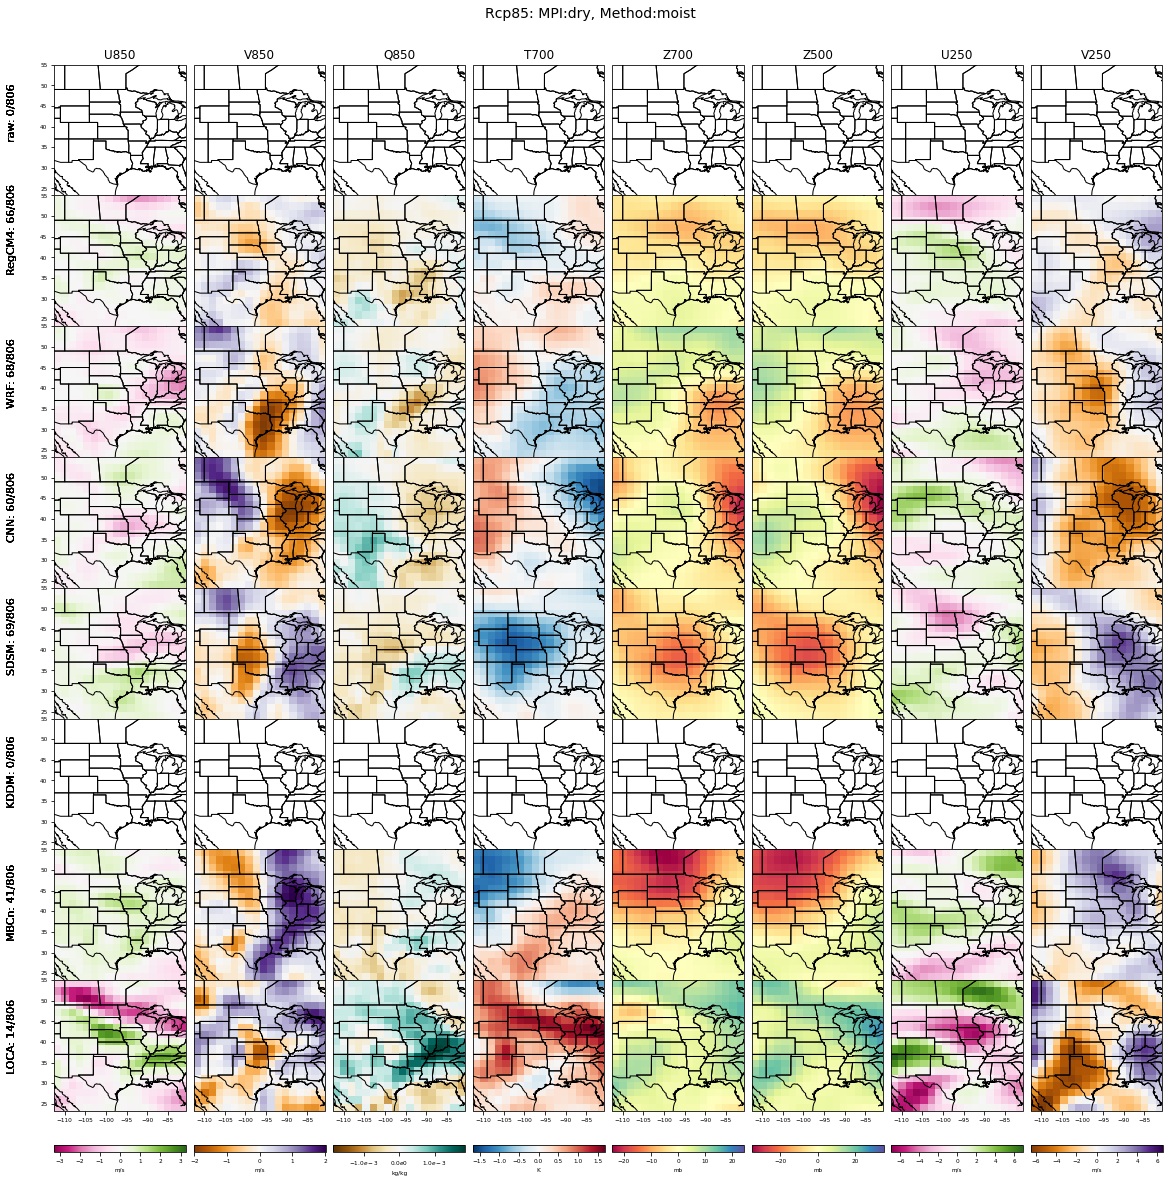

In [137]:
model_names = ['raw','RegCM4','WRF','CNN','SDSM','KDDM','MBCn','LOCA']
#mpiwet_methoddry_counts
plot_postage(mpidry_methodmoist_list, model_names, mpidry_methodmoist_counts, mpi_maydays_count, 'Rcp85: MPI:dry, Method:moist')


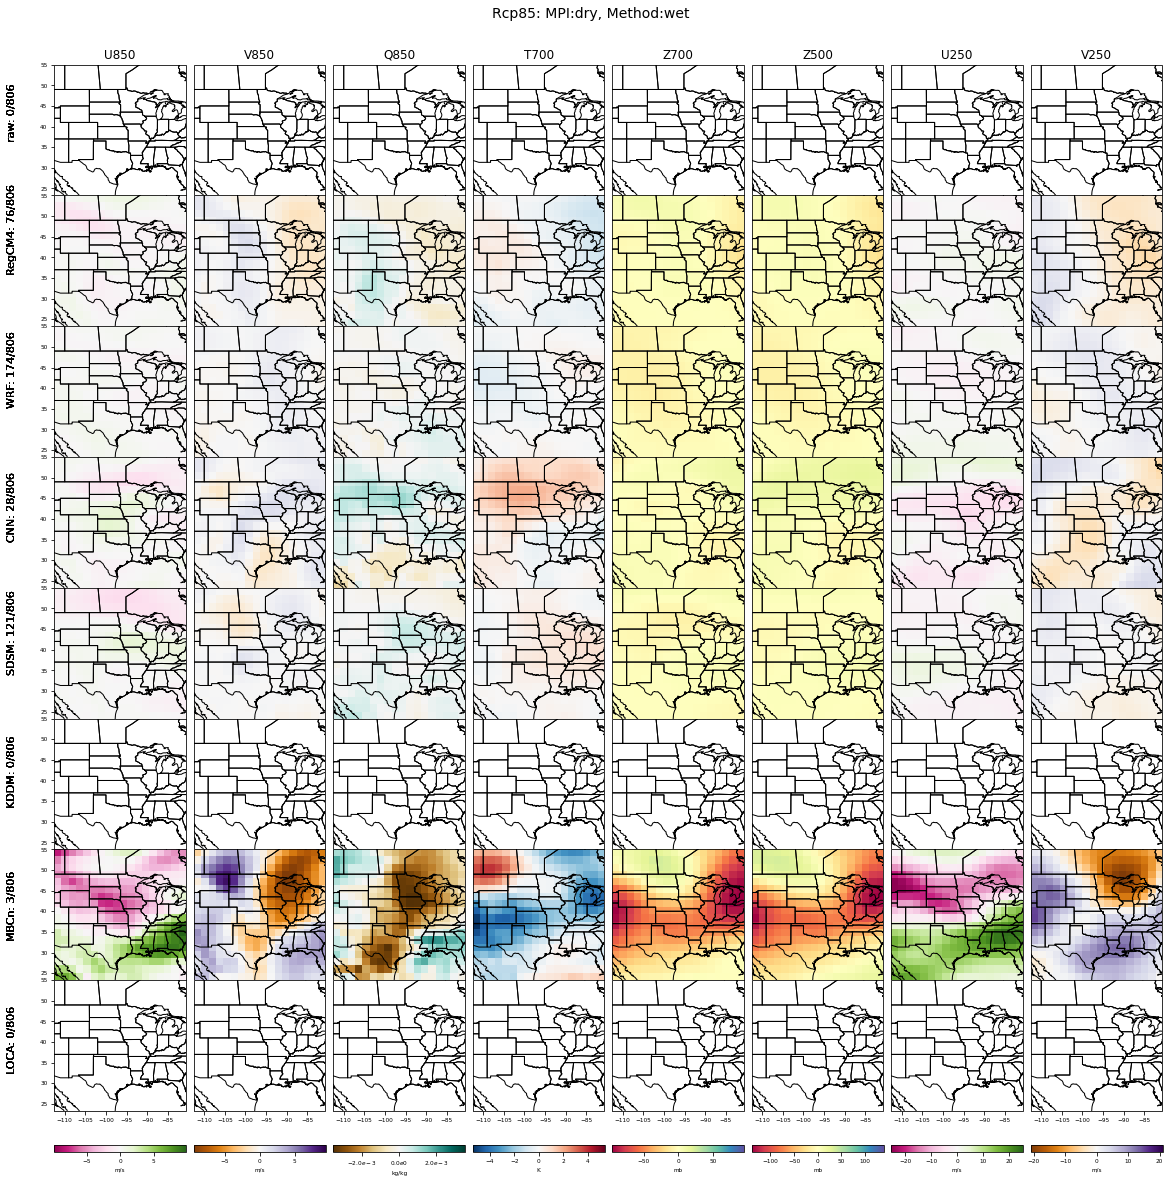

In [138]:
plot_postage(mpidry_methodwet_list, model_names, mpidry_methodwet_counts, mpi_maydays_count, 'Rcp85: MPI:dry, Method:wet')


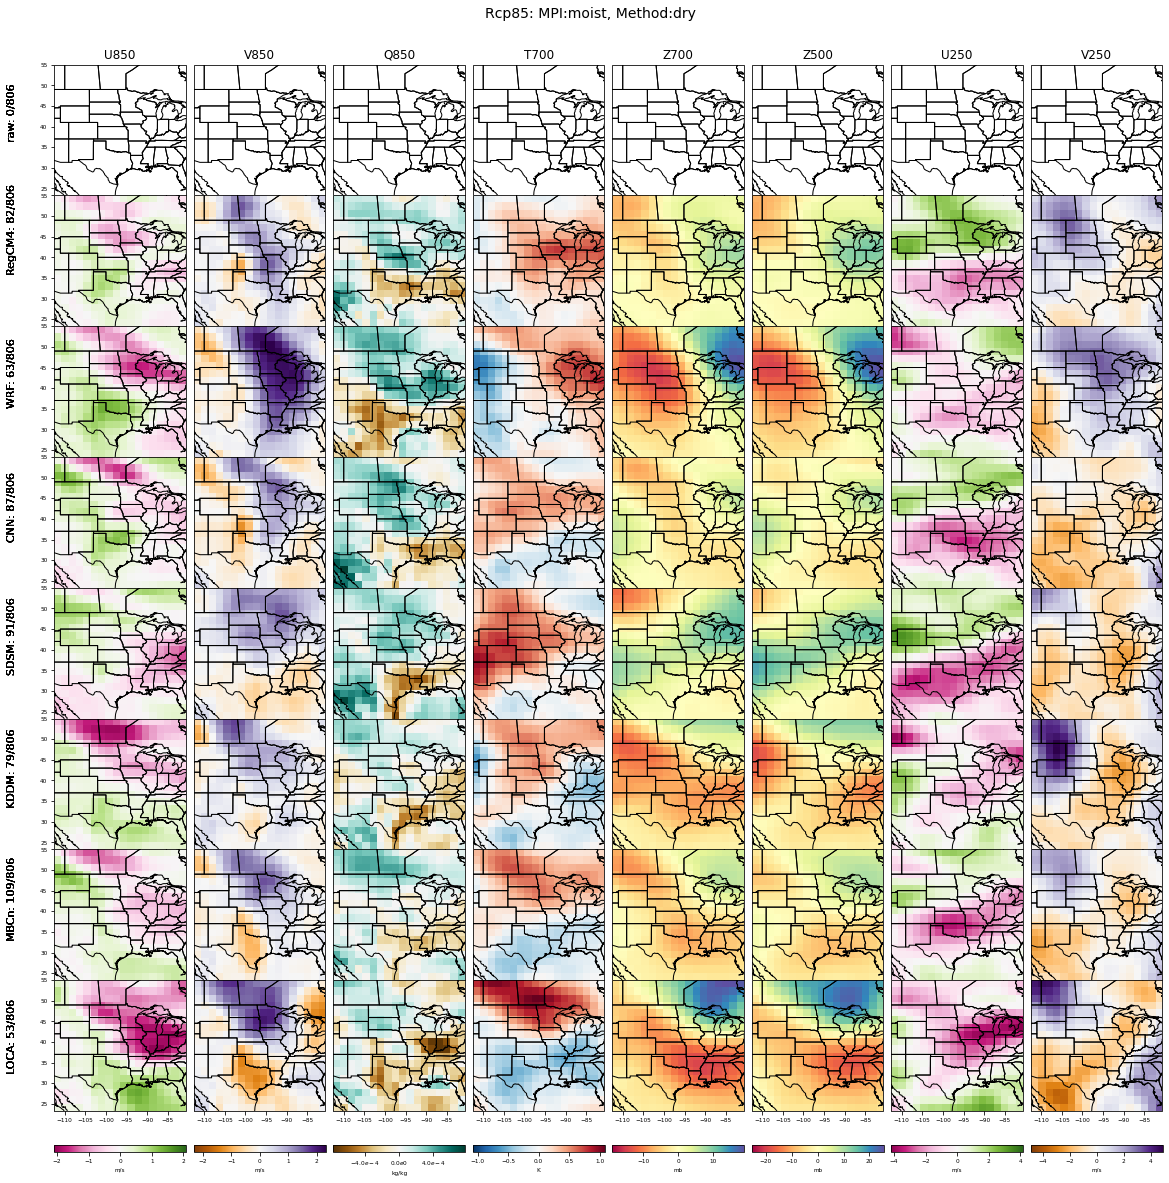

In [139]:
plot_postage(mpimoist_methoddry_list, model_names, mpimoist_methoddry_counts, mpi_maydays_count, 'Rcp85: MPI:moist, Method:dry')


In [140]:
len(mpidry_methodwet_list)

8

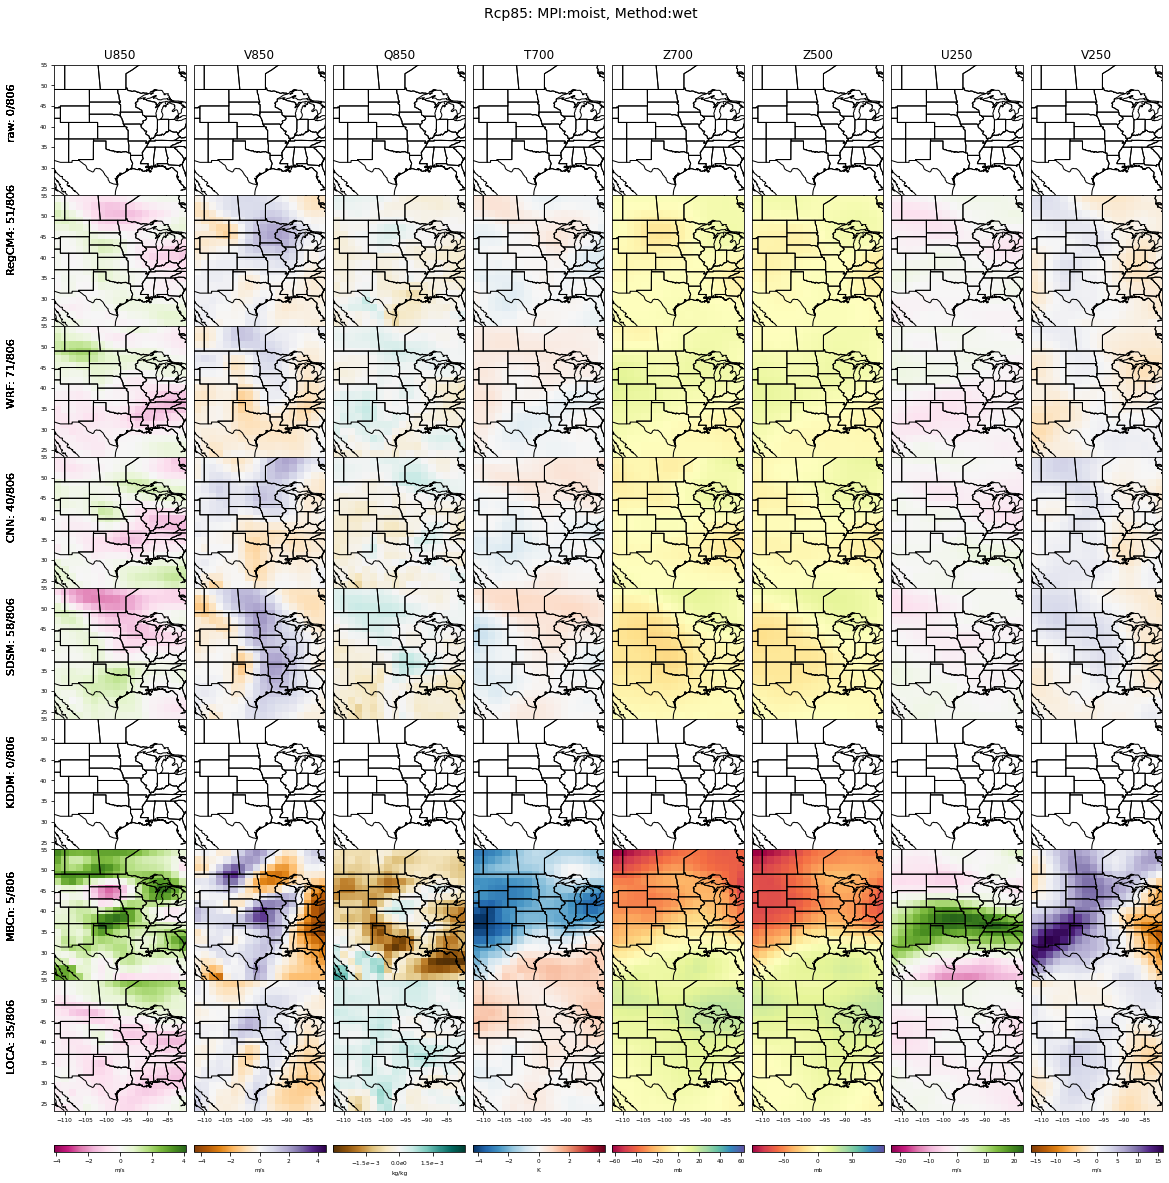

In [141]:
plot_postage(mpimoist_methodwet_list, model_names, mpimoist_methodwet_counts, mpi_maydays_count, 'Rcp85: MPI:moist, Method:wet')


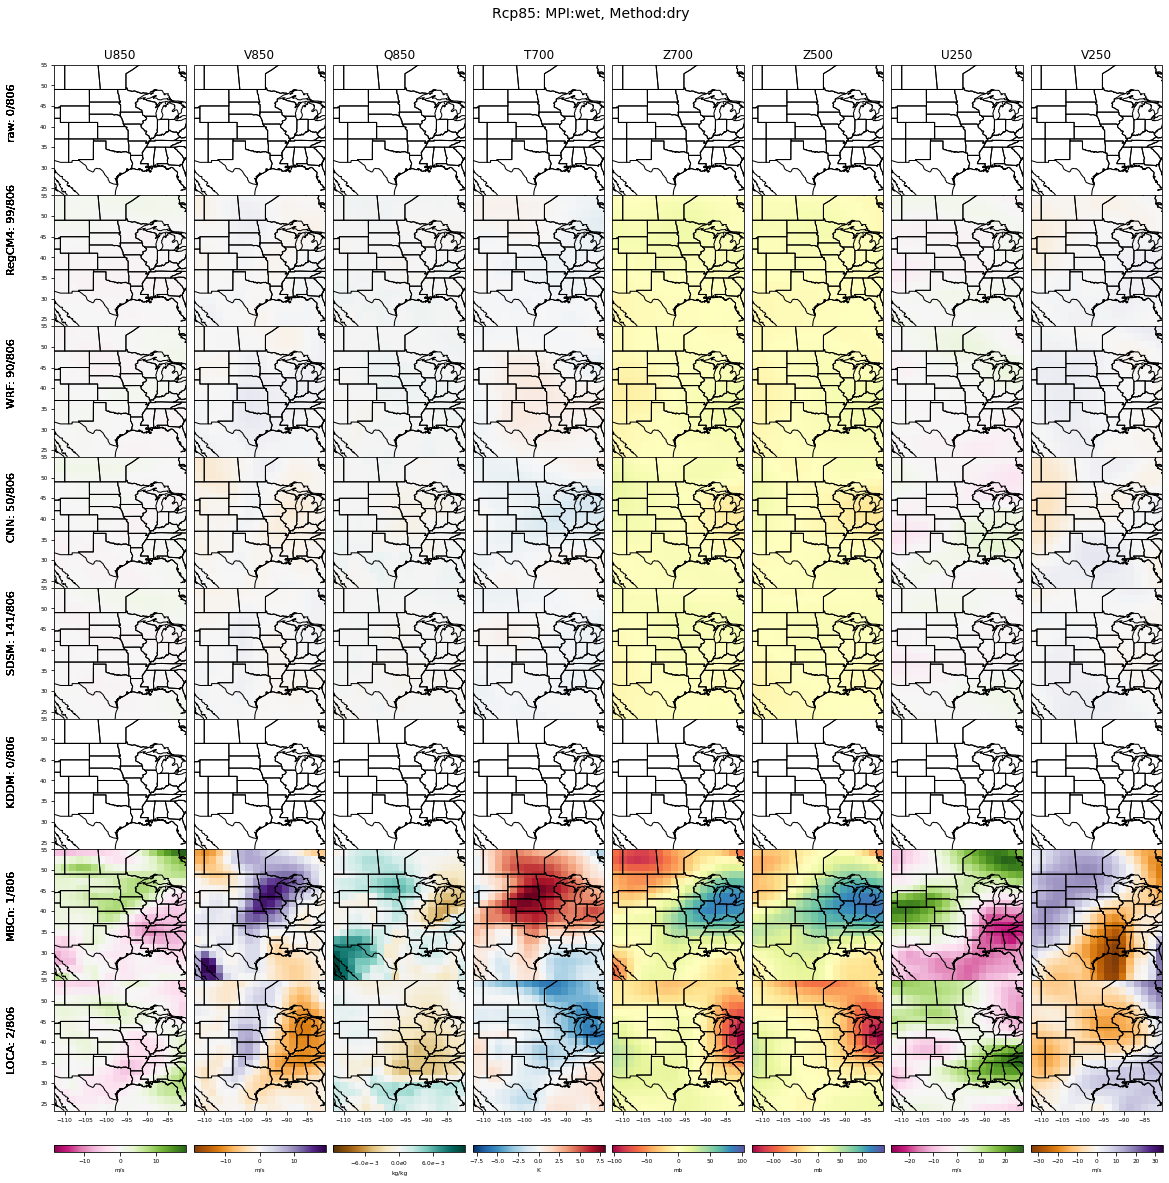

In [142]:
plot_postage(mpiwet_methoddry_list, model_names, mpiwet_methoddry_counts, mpi_maydays_count, 'Rcp85: MPI:wet, Method:dry')


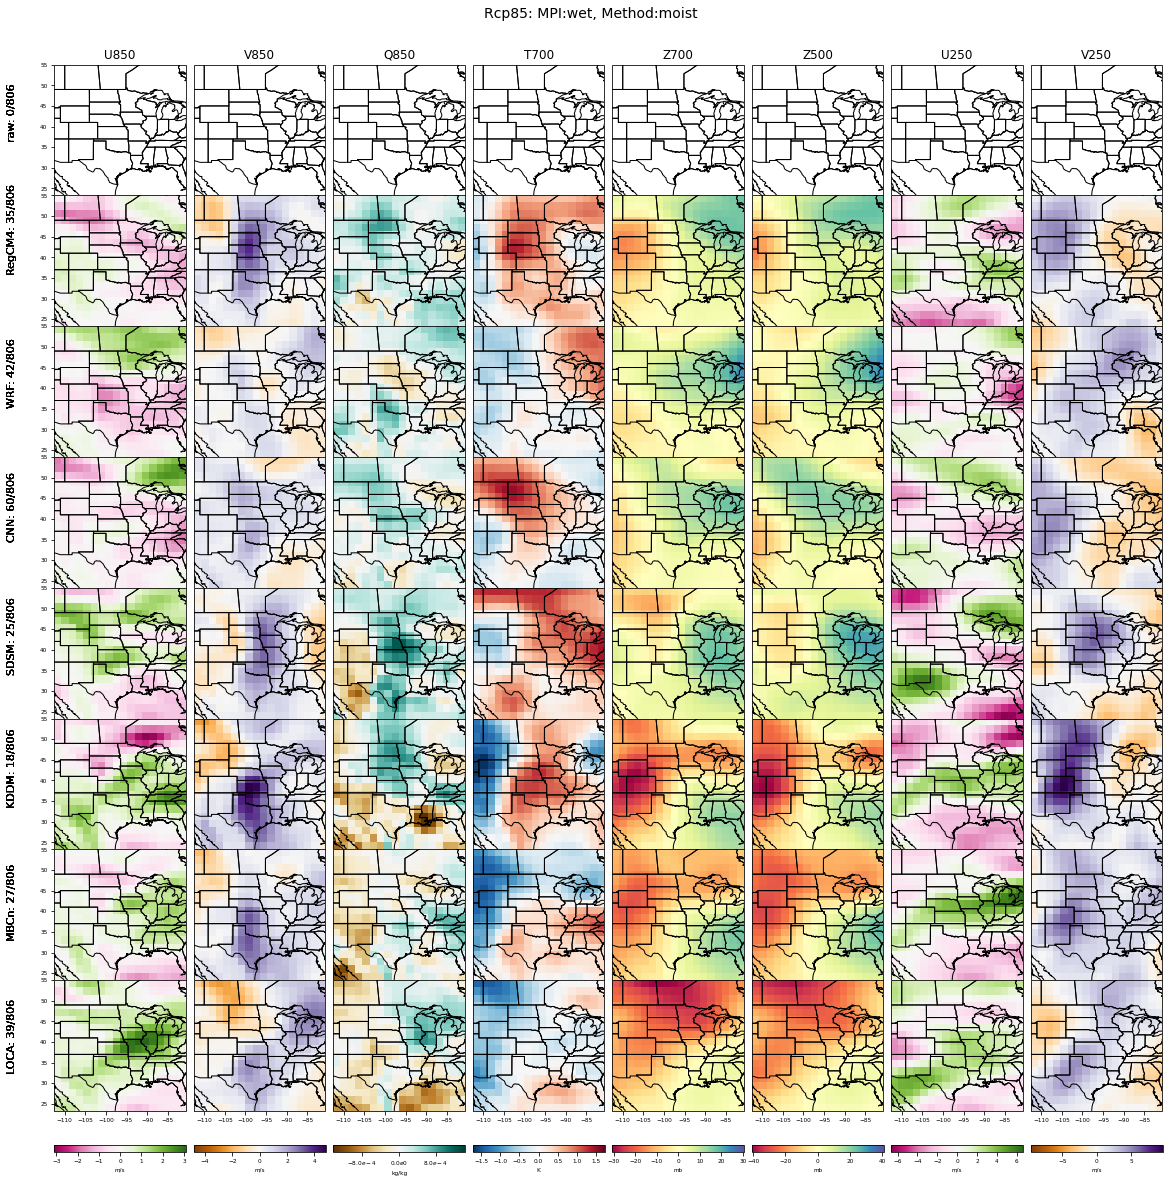

In [143]:
plot_postage(mpiwet_methodmoist_list, model_names, mpiwet_methodmoist_counts, mpi_maydays_count, 'Rcp85: MPI:wet, Method:moist')
